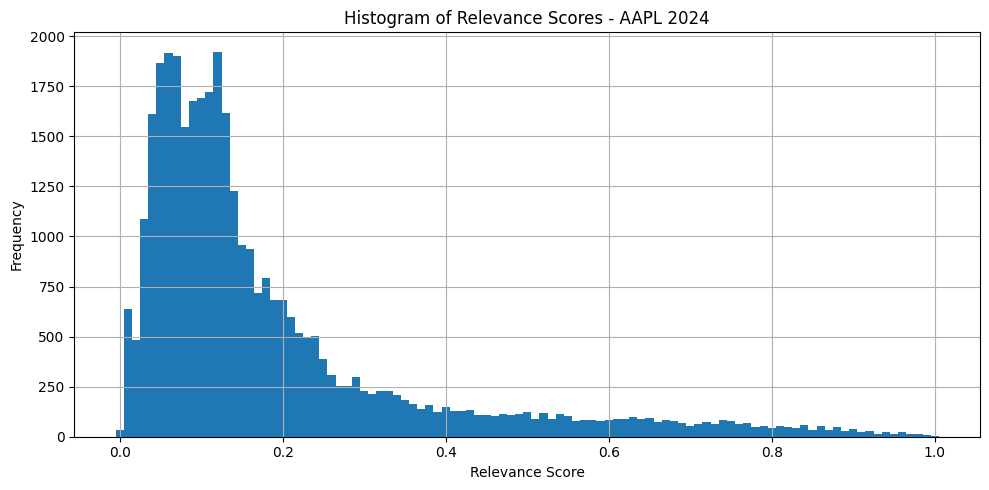

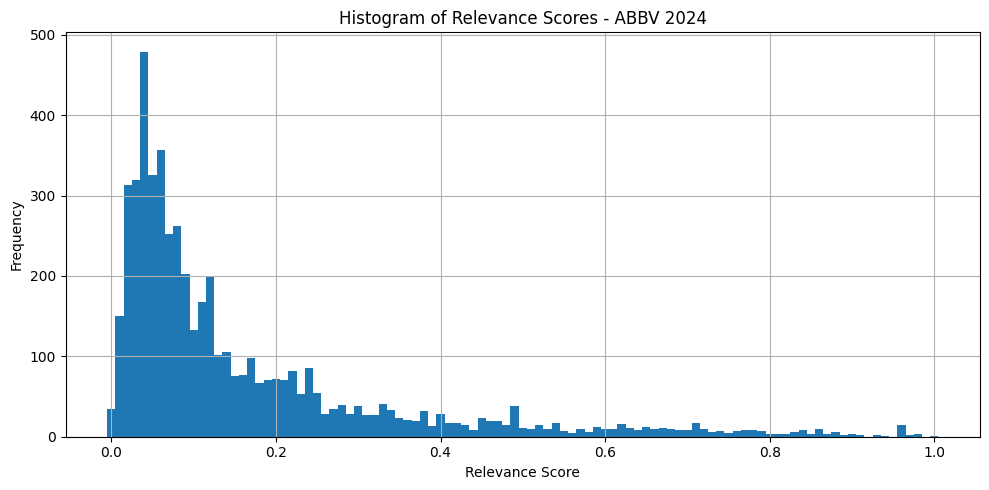

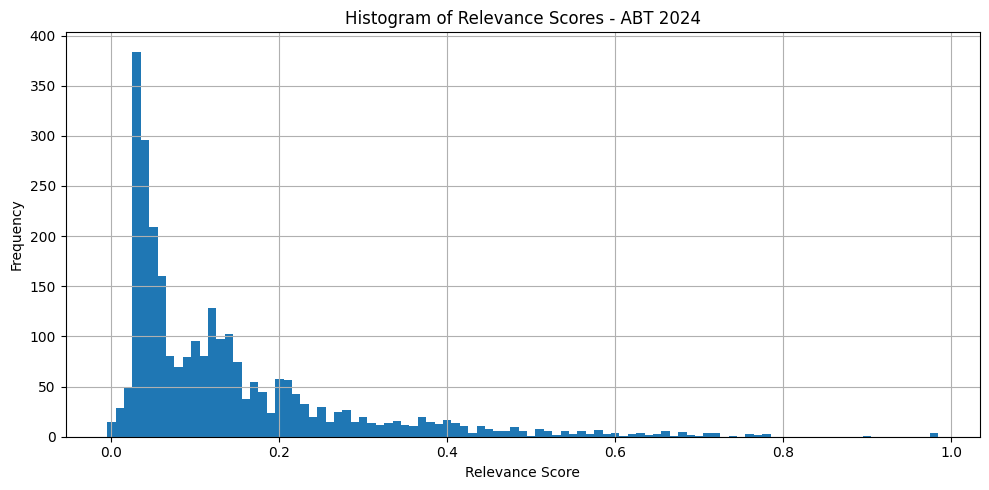

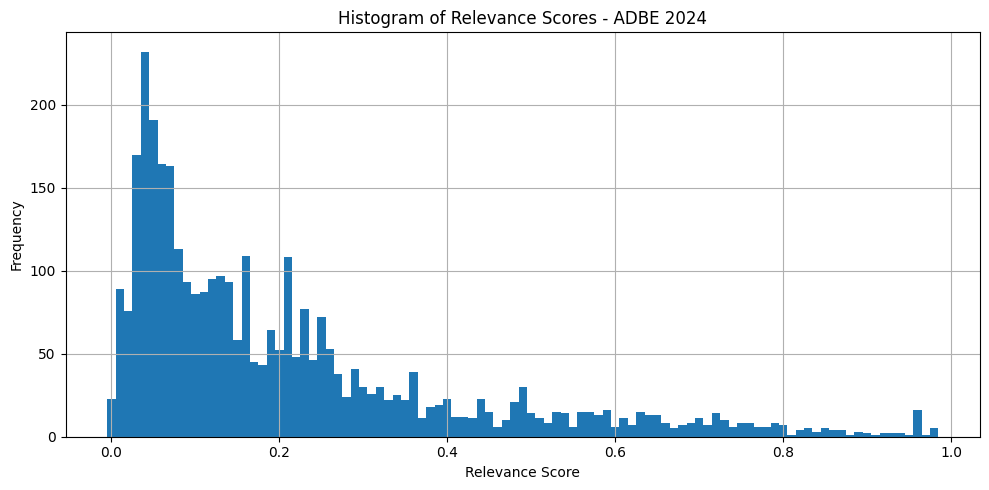

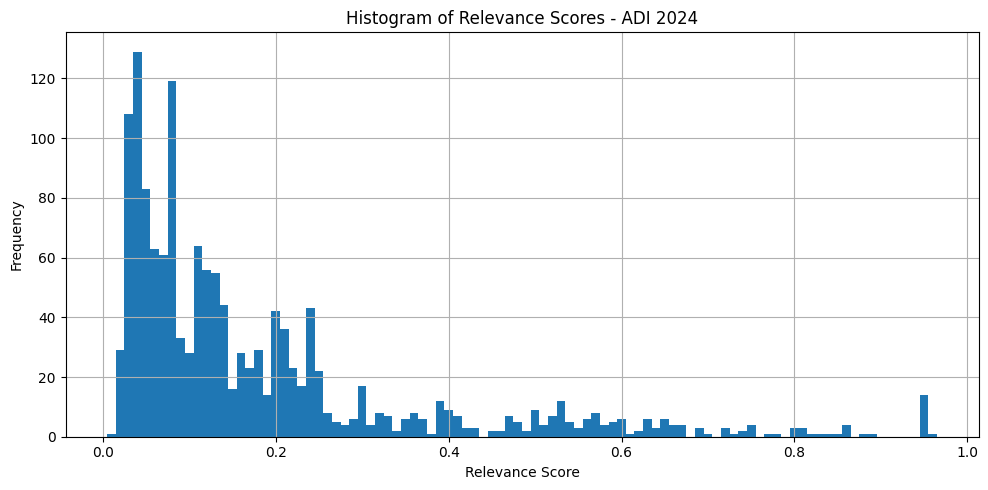

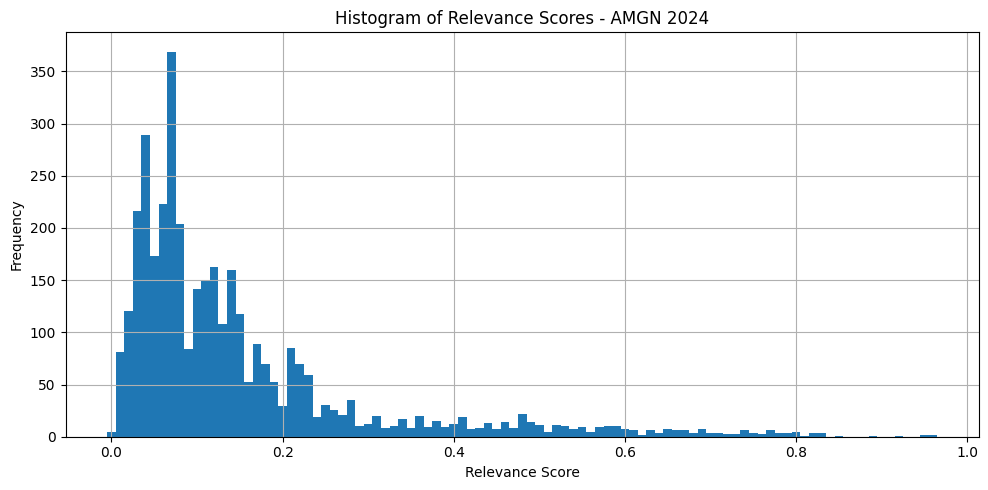

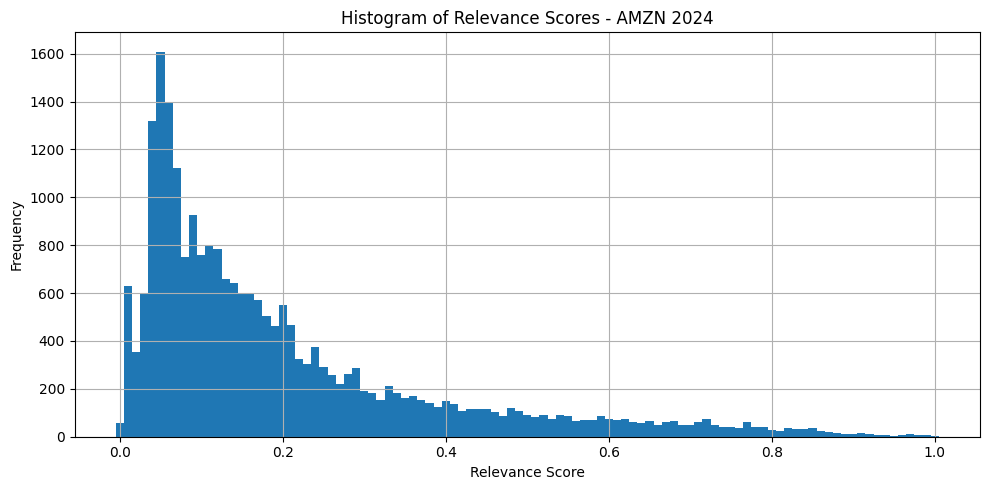

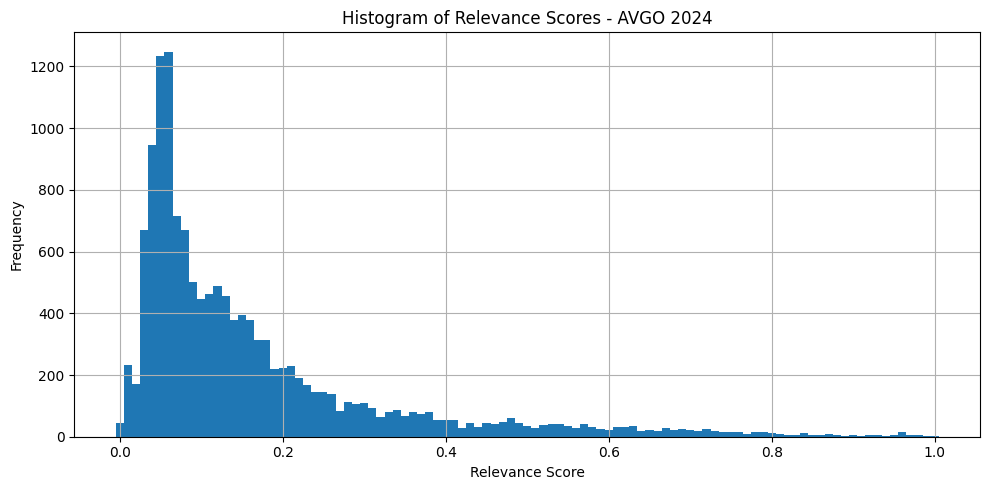

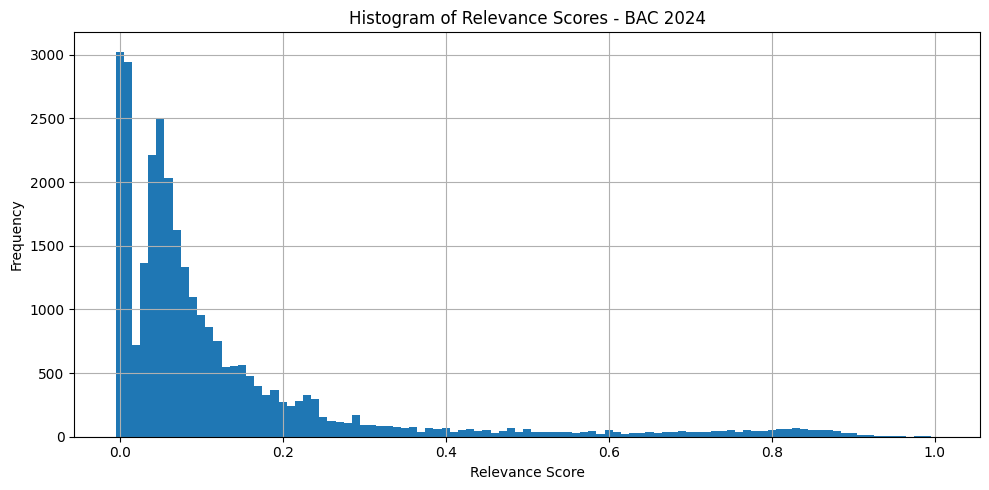

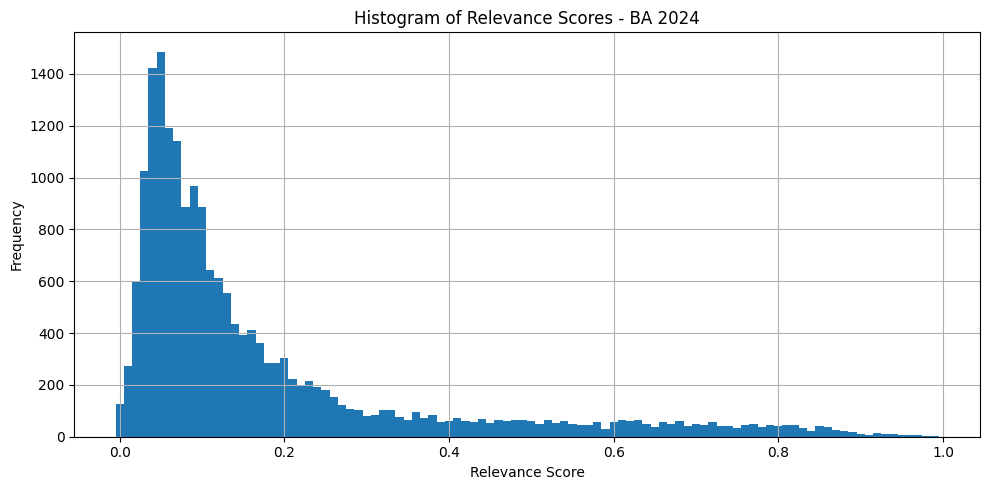

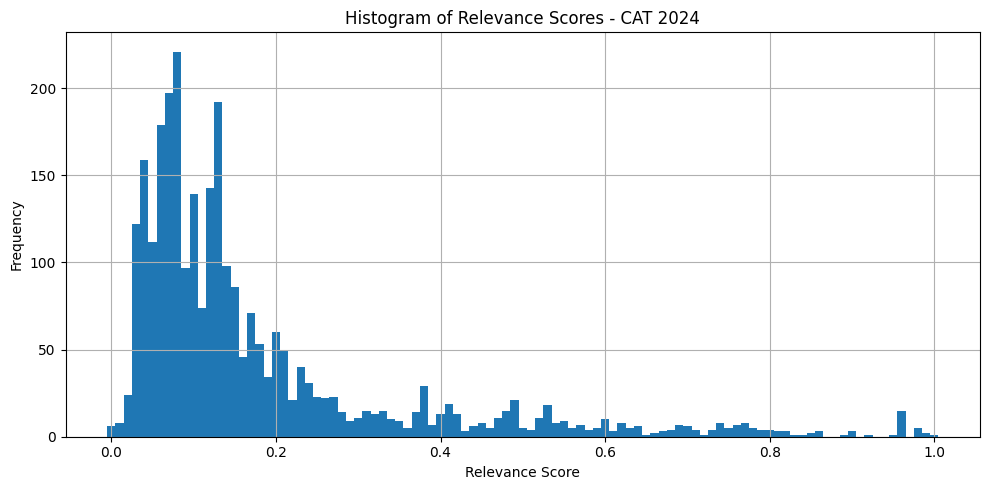

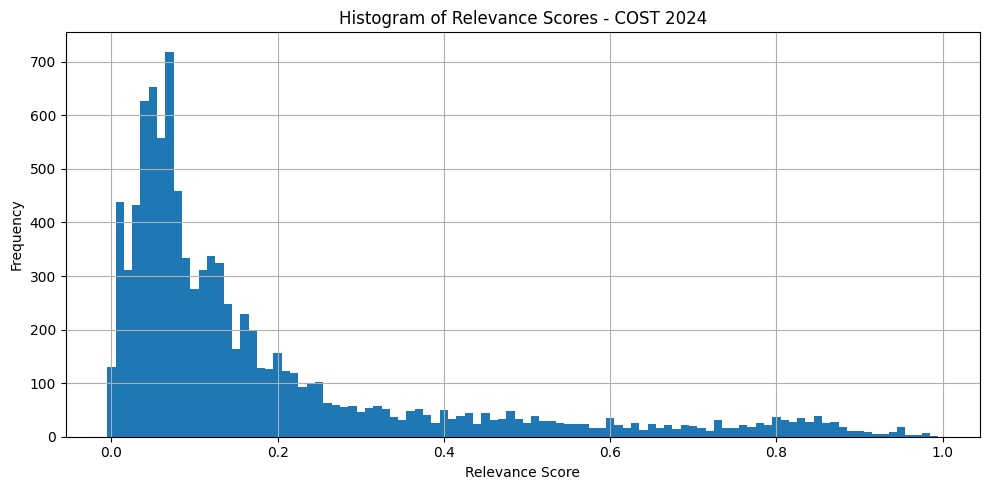

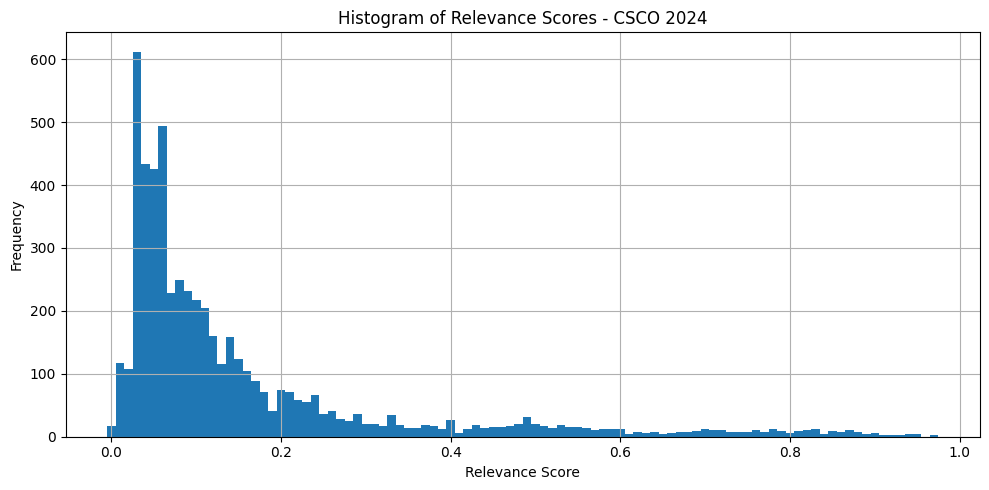

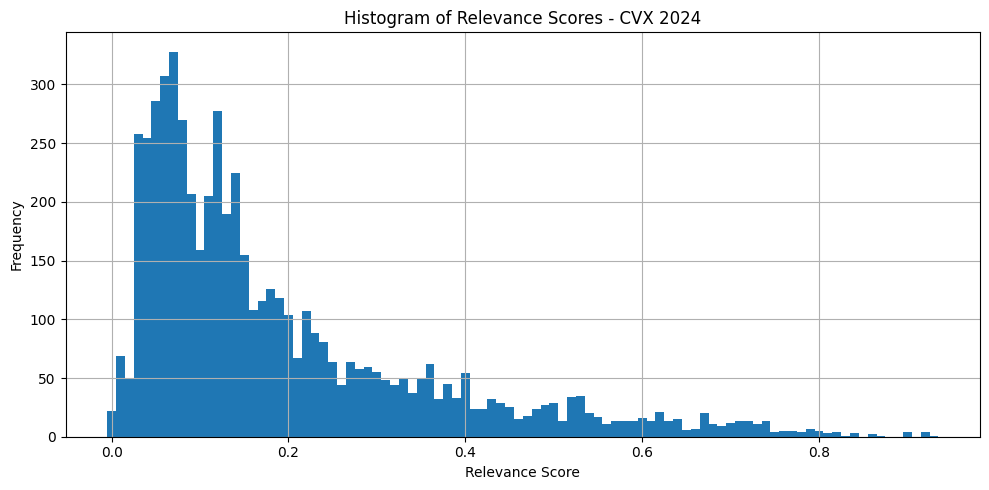

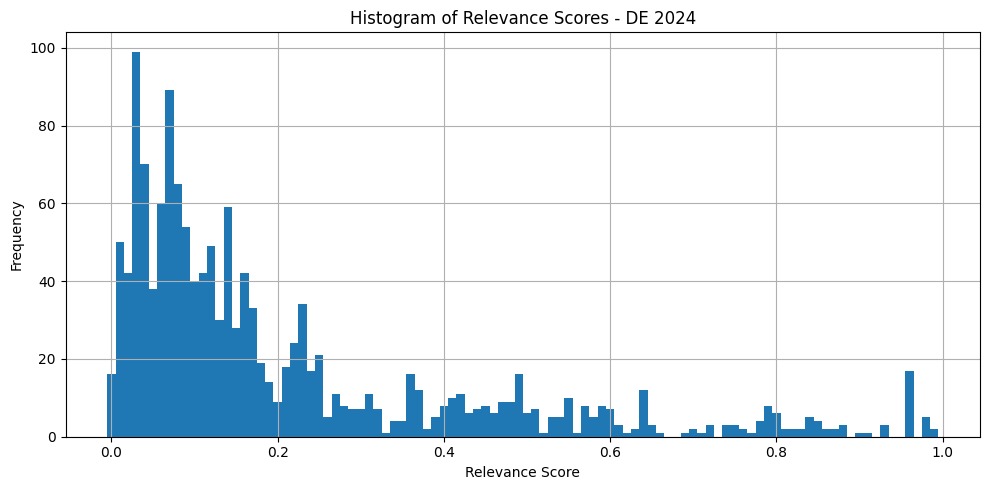

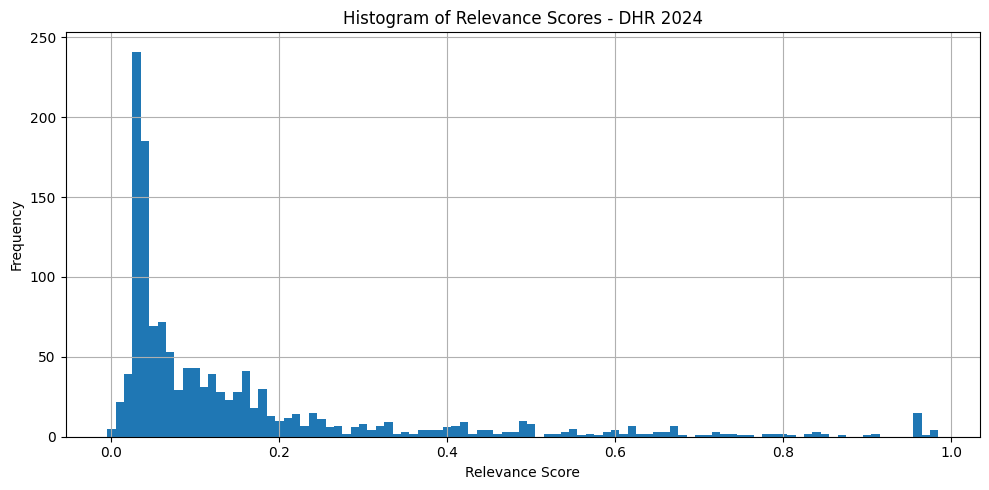

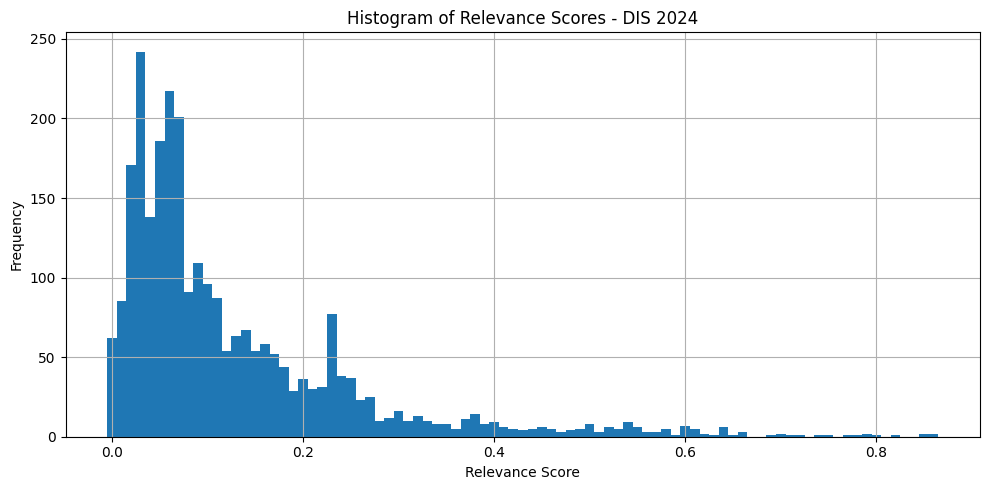

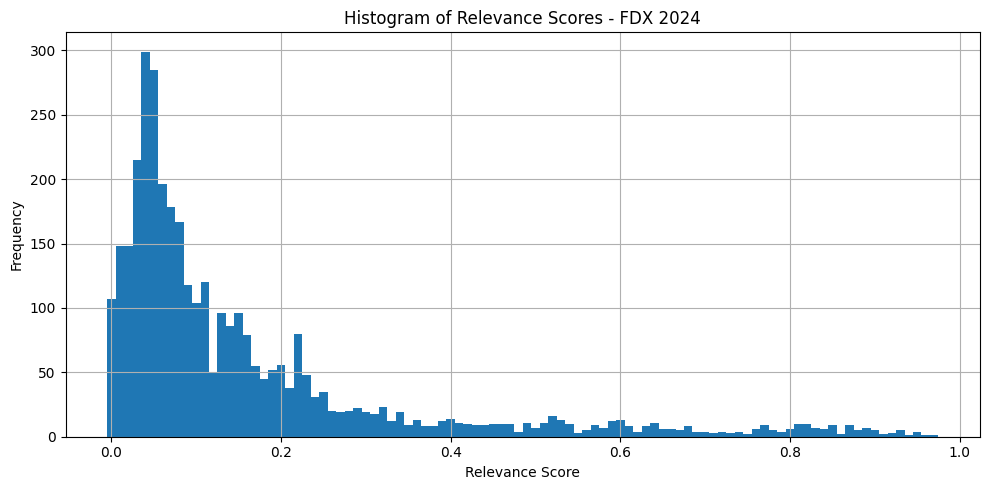

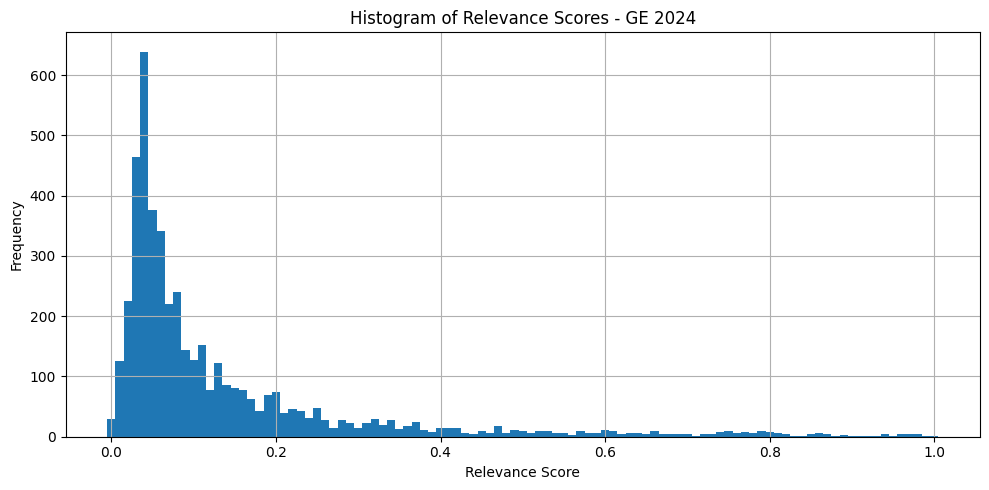

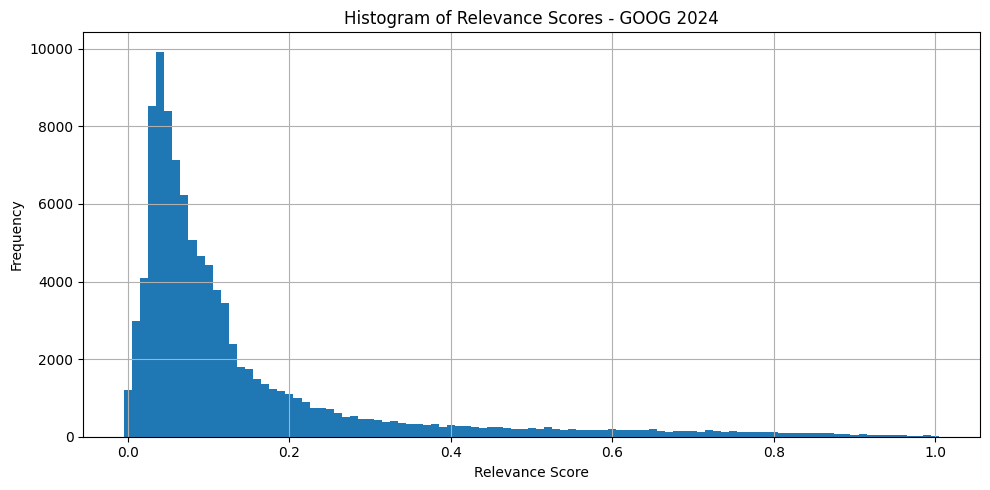

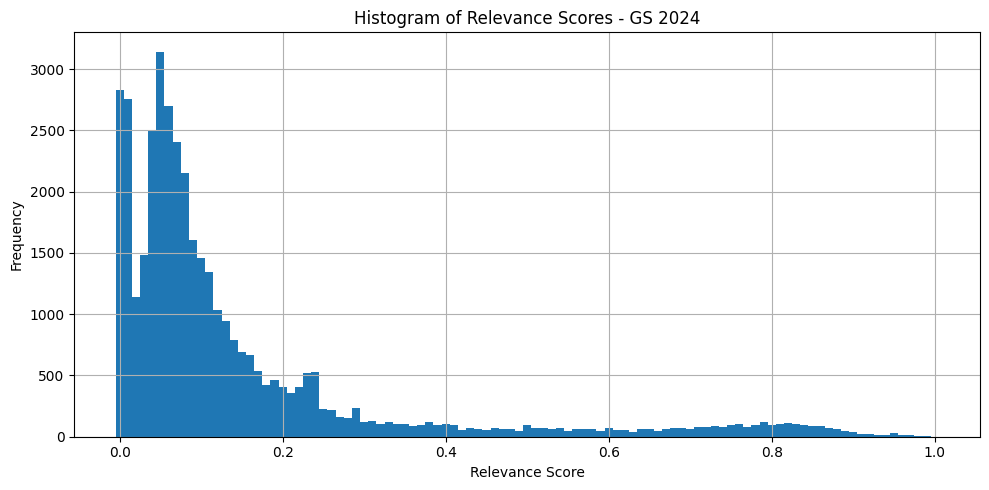

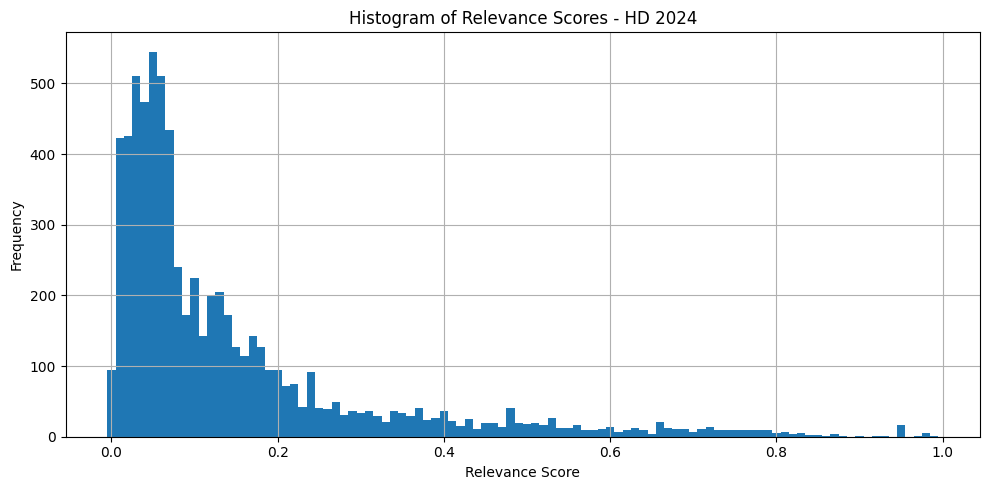

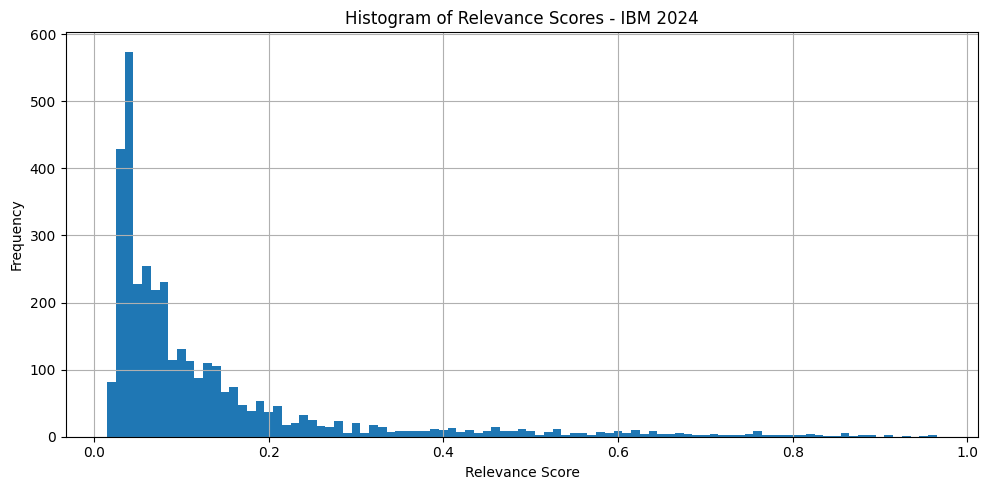

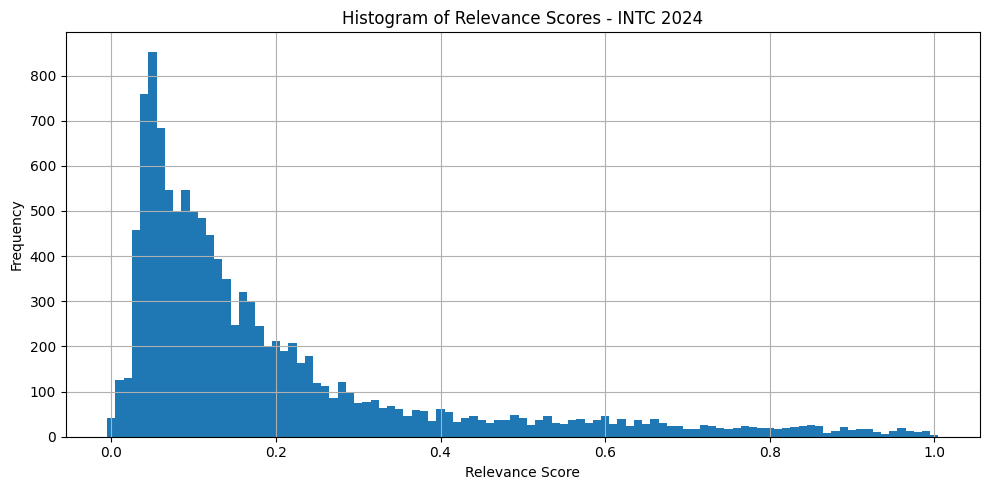

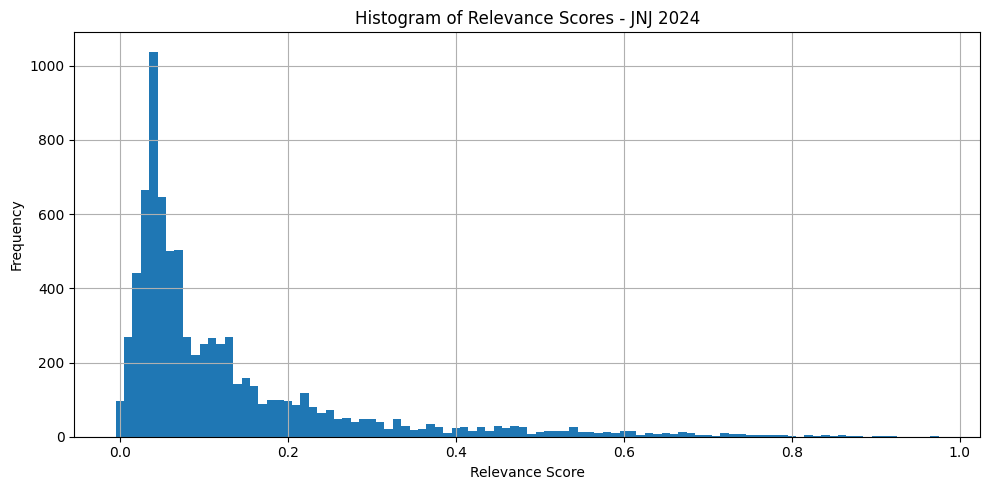

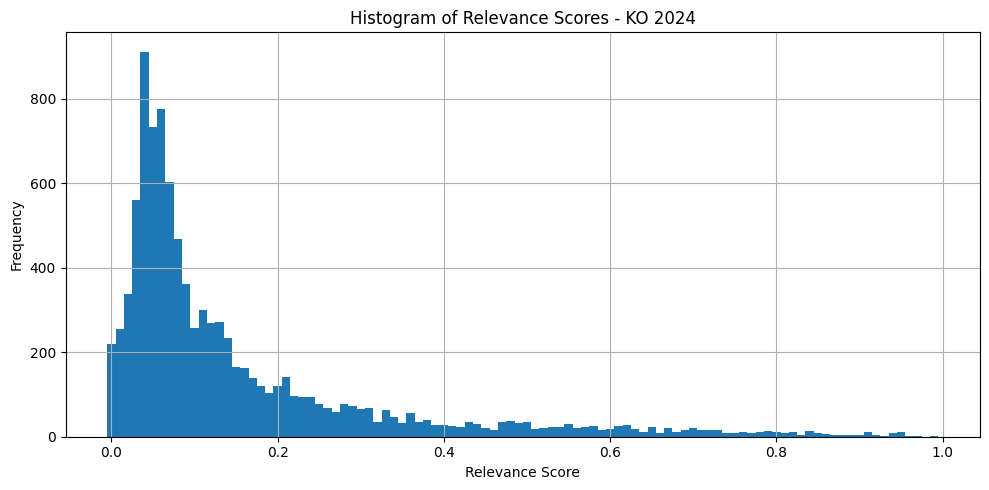

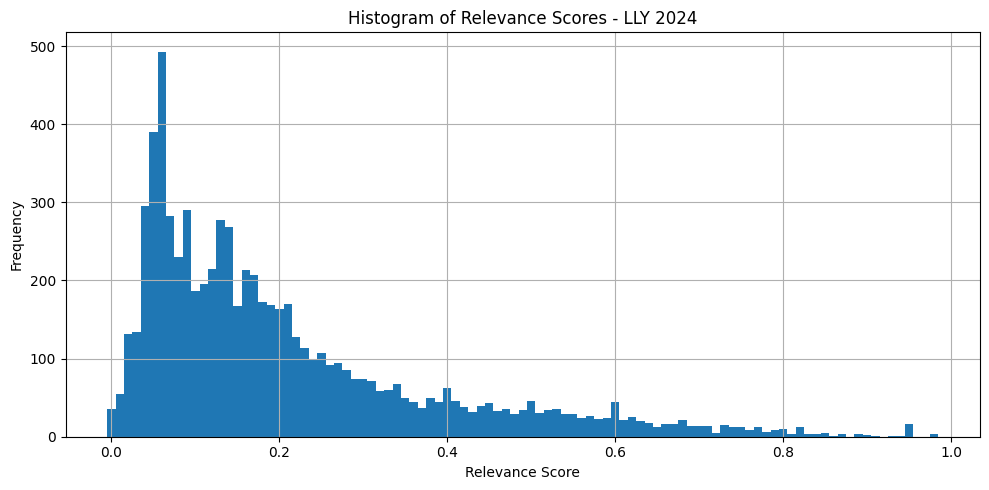

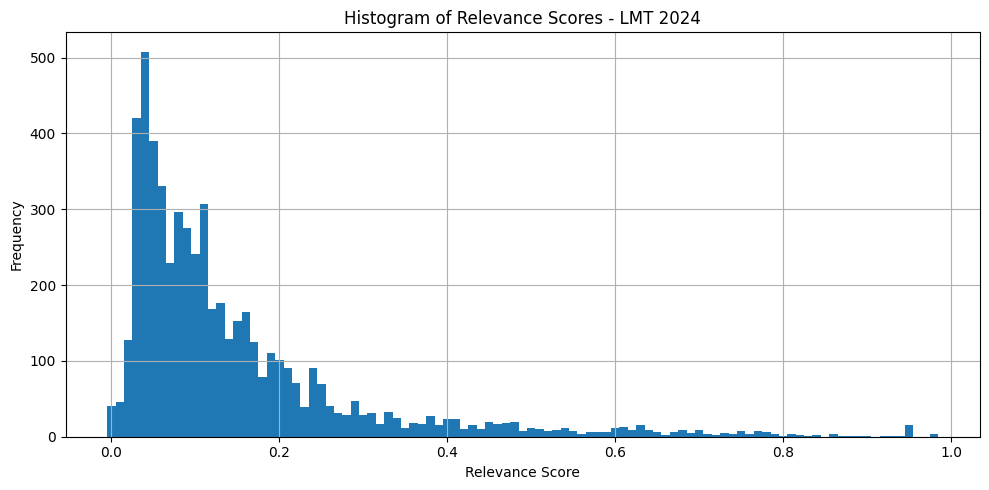

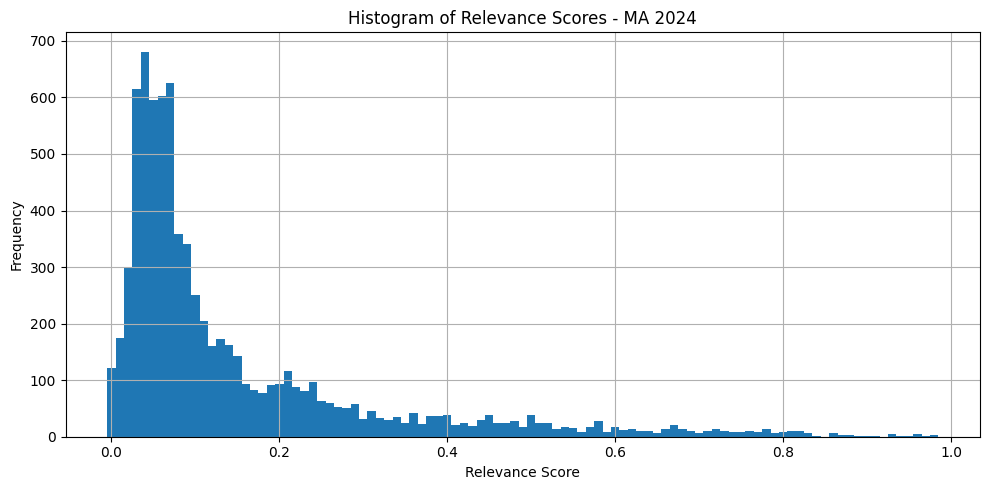

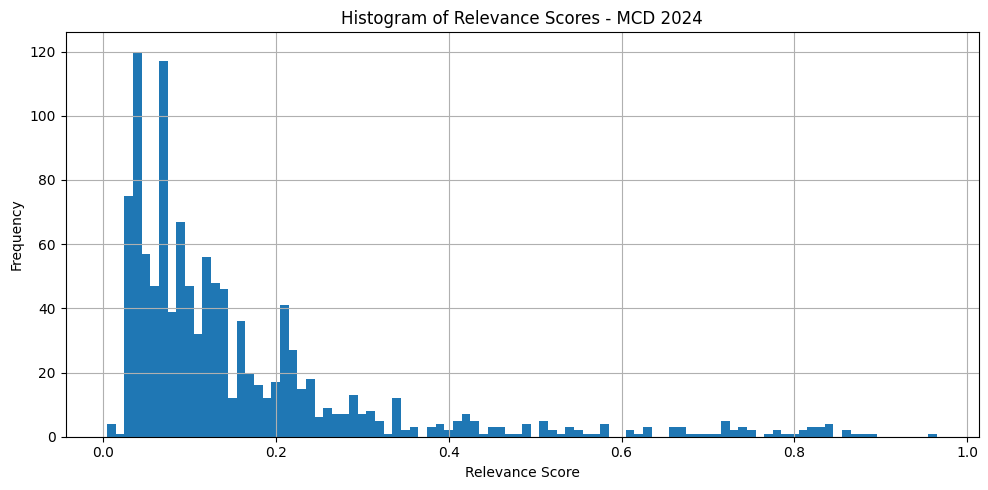

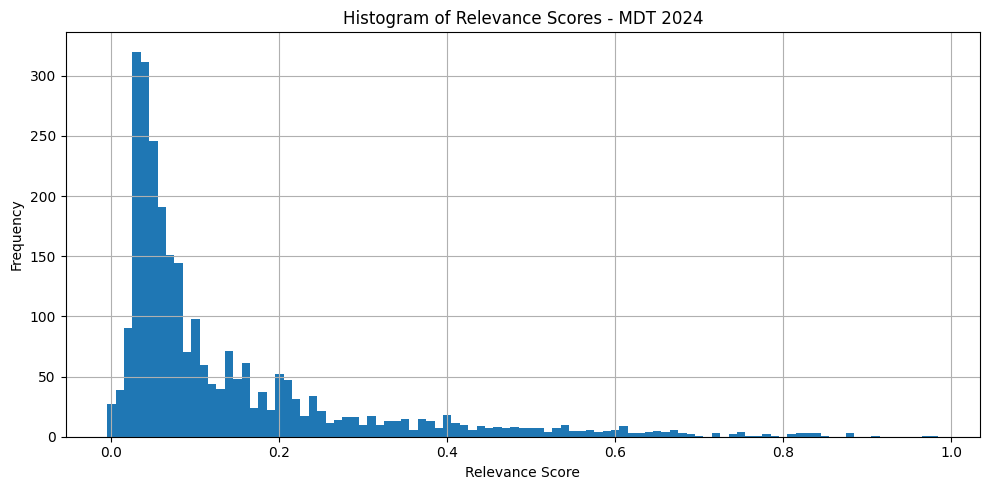

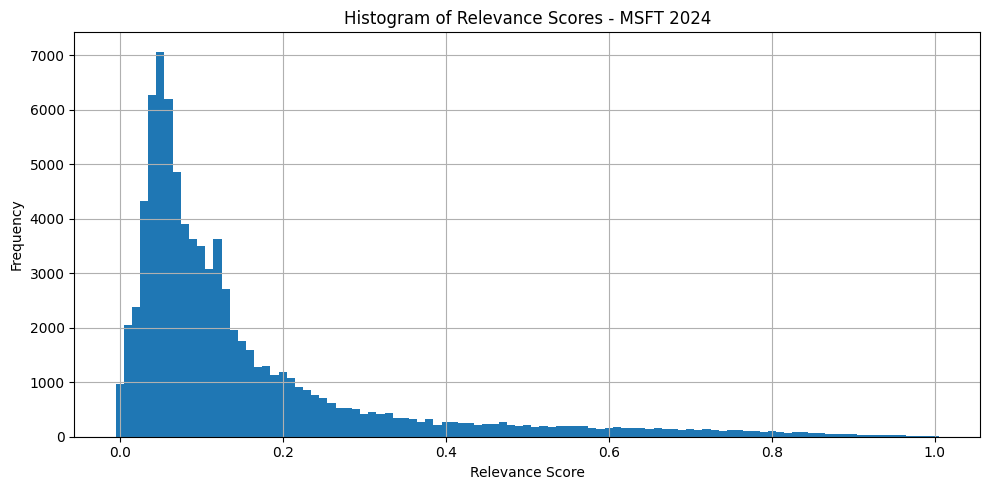

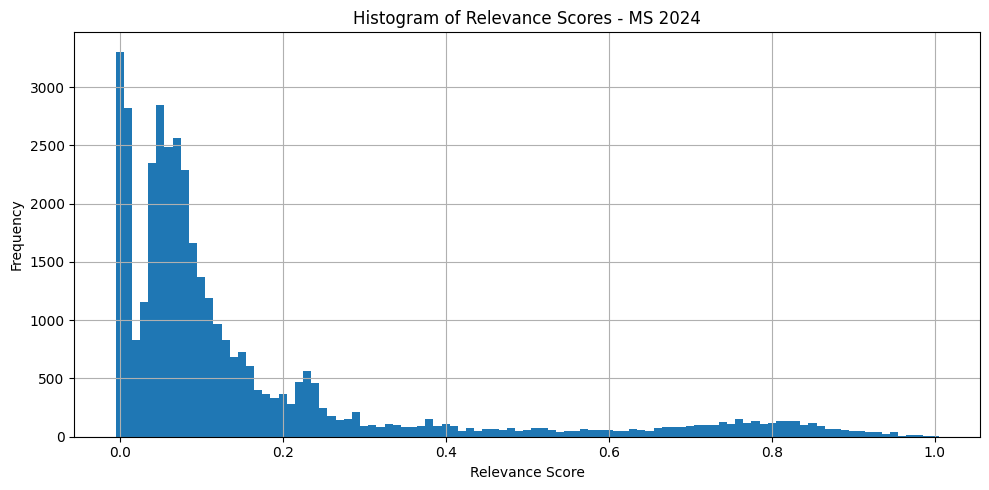

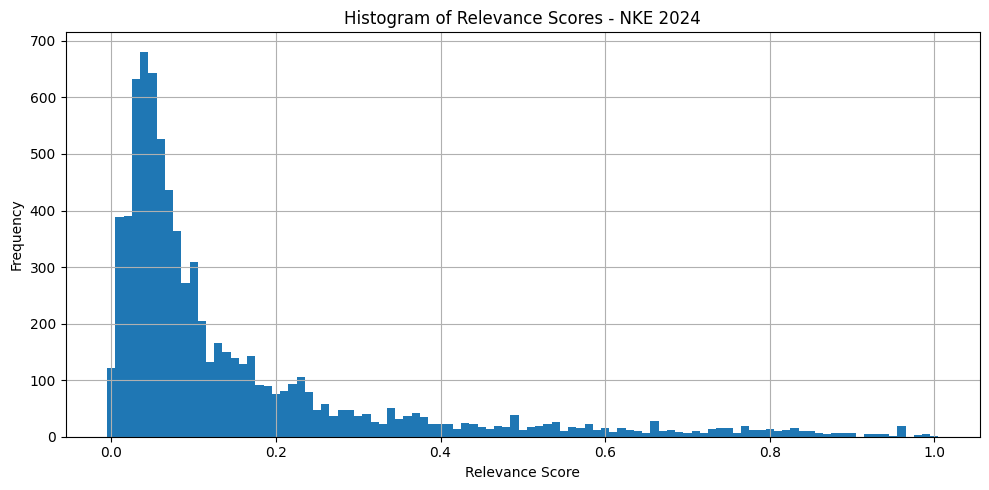

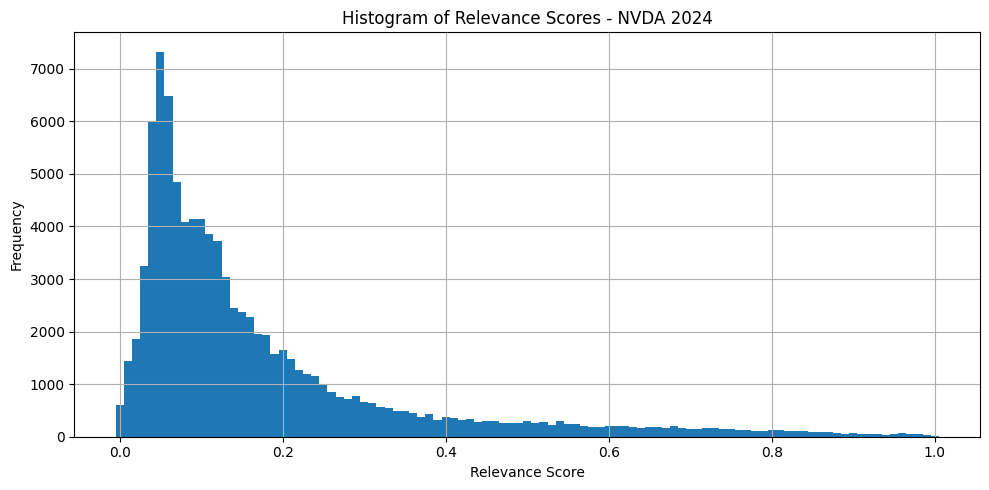

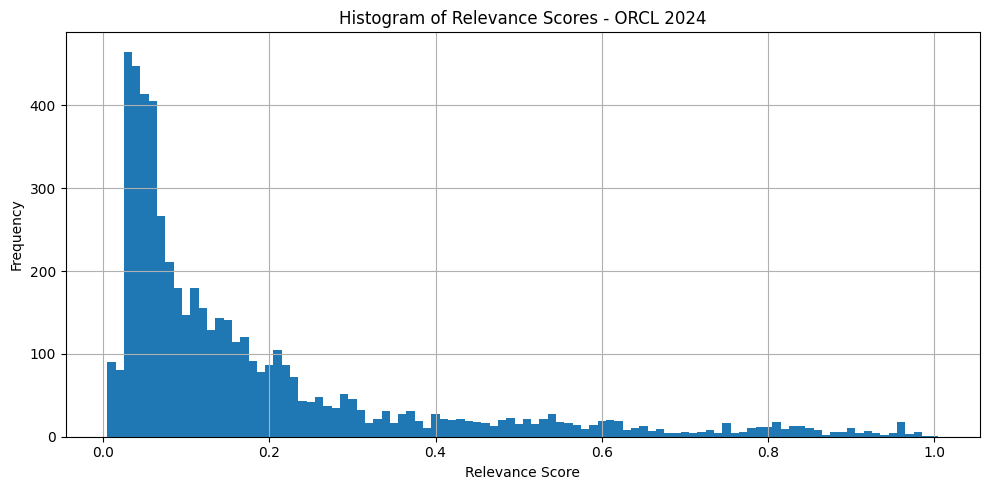

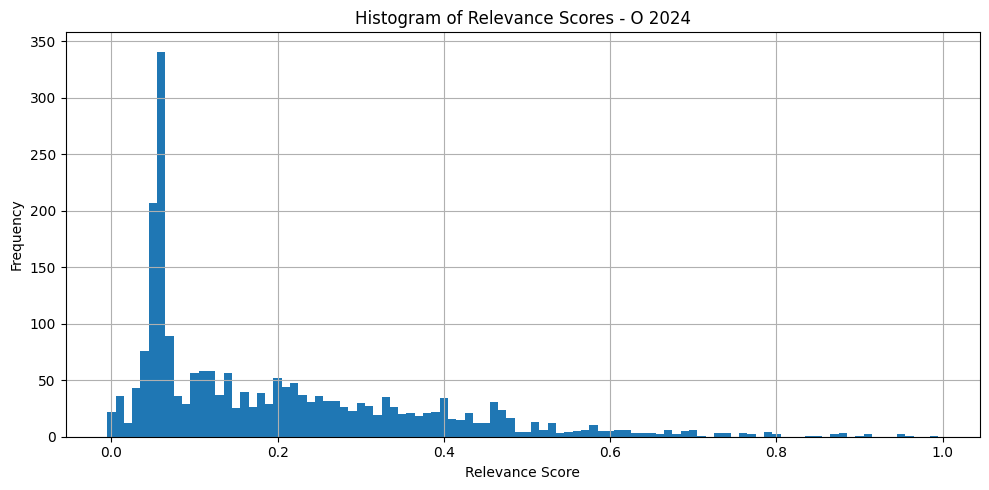

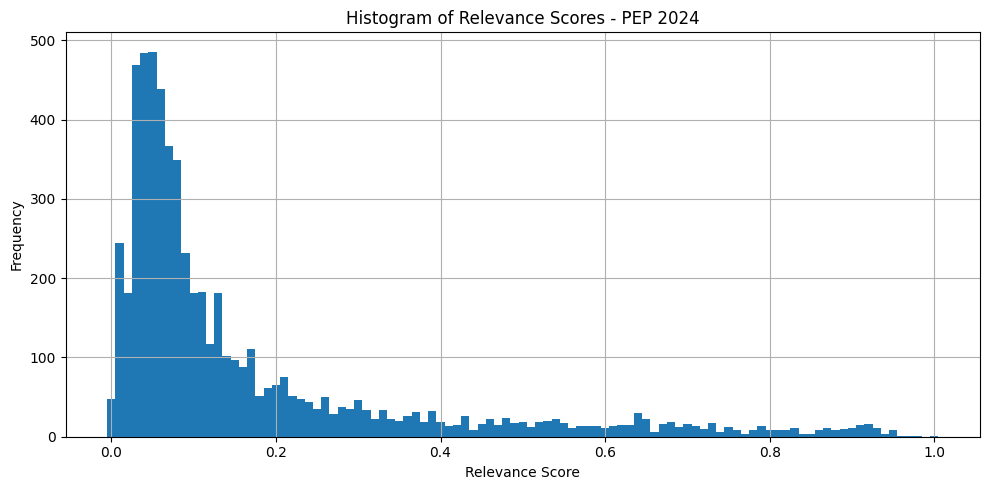

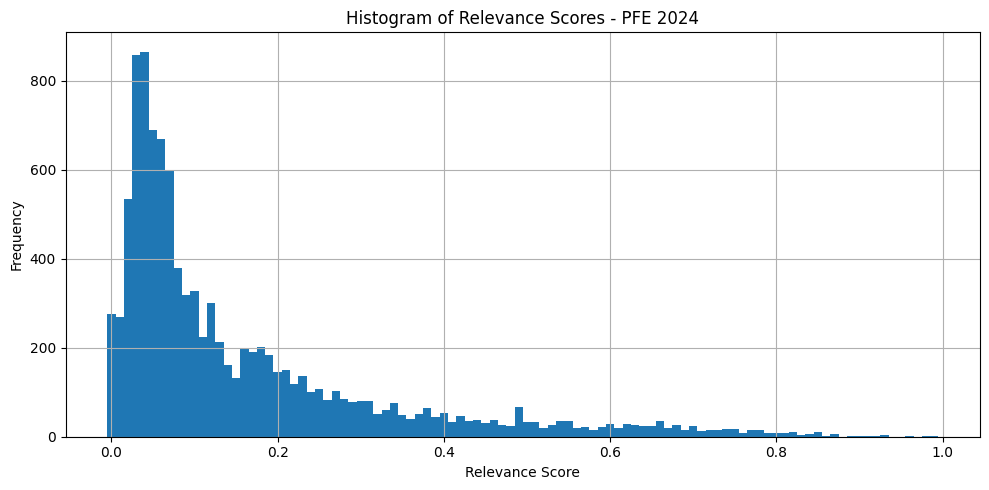

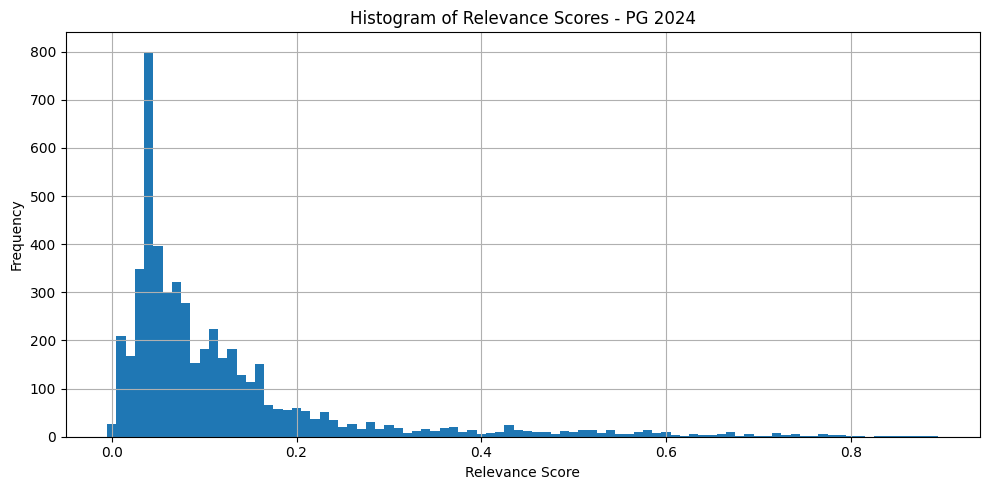

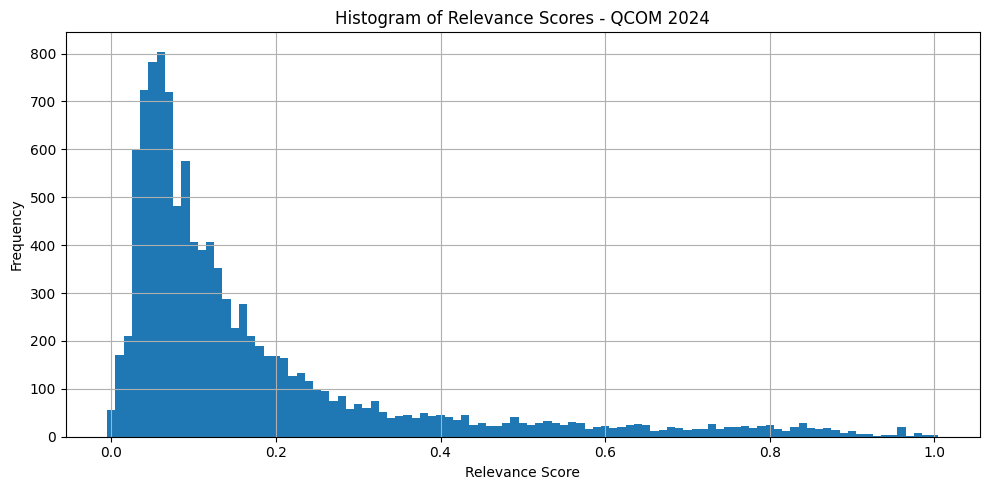

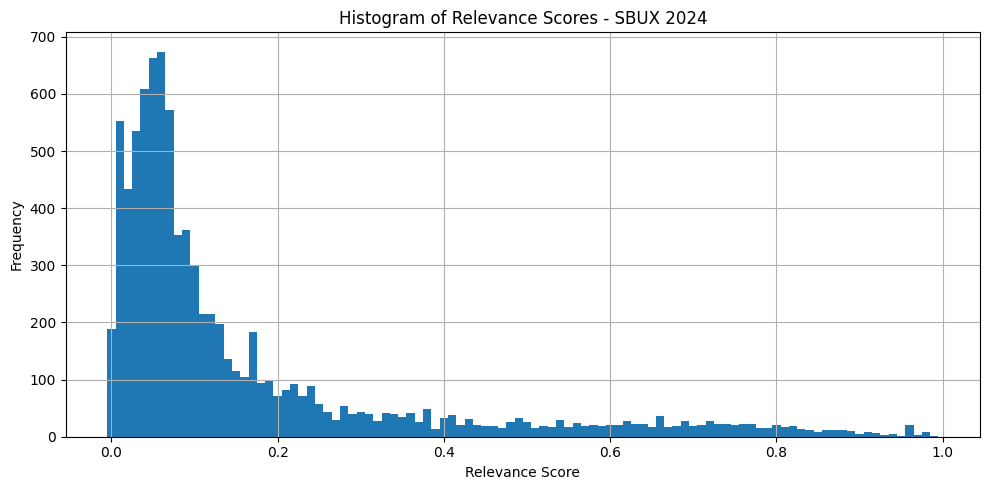

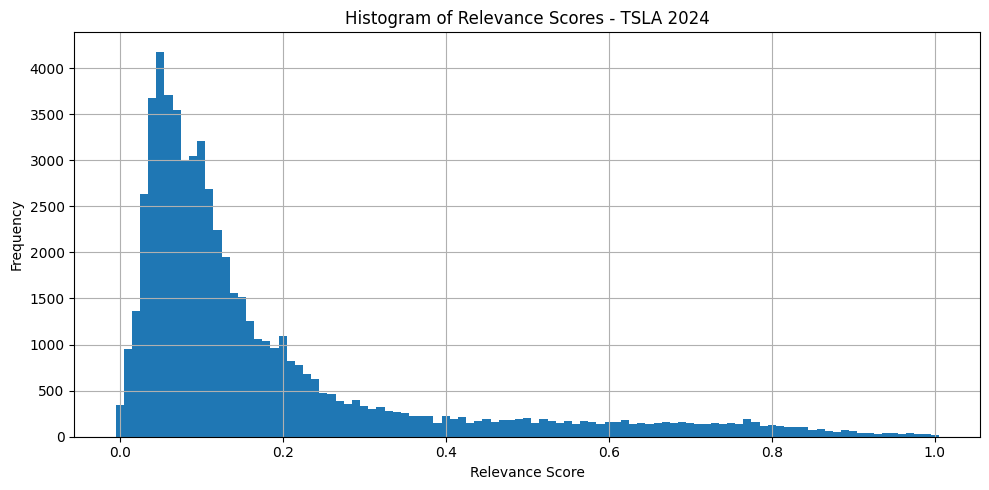

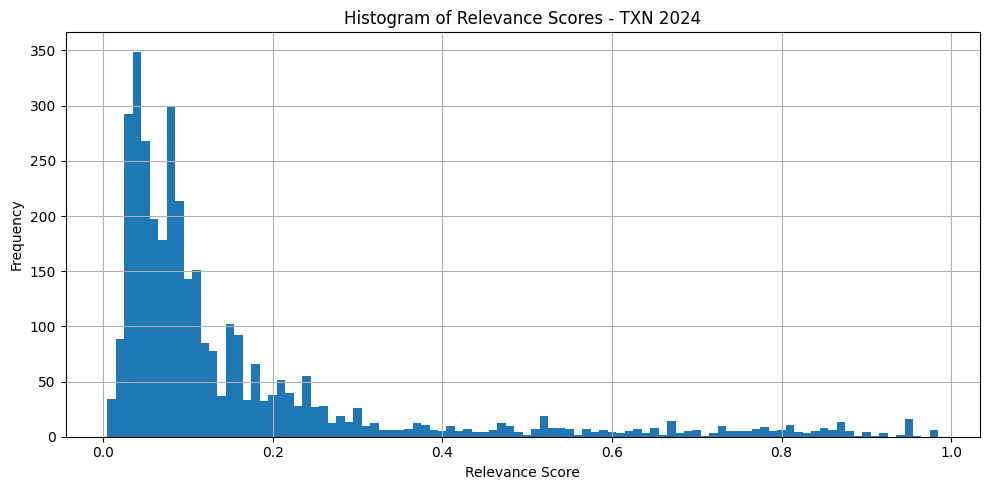

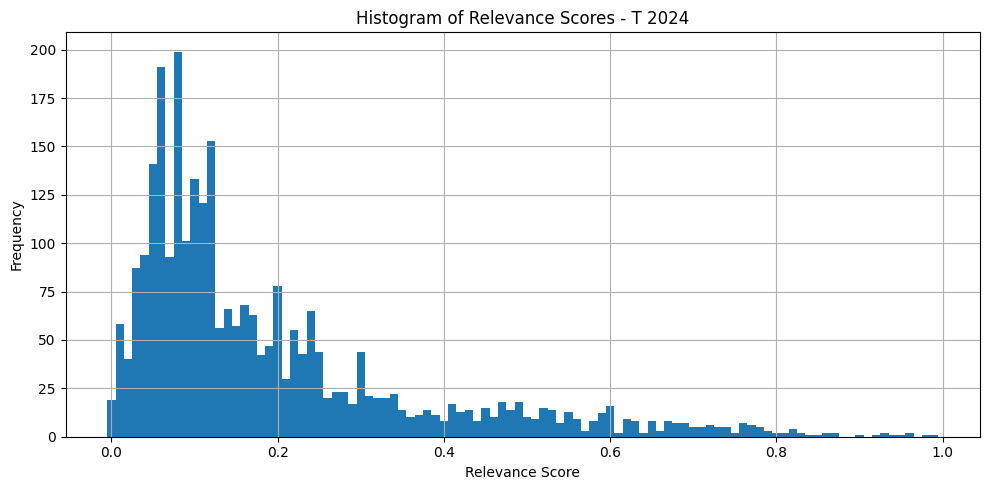

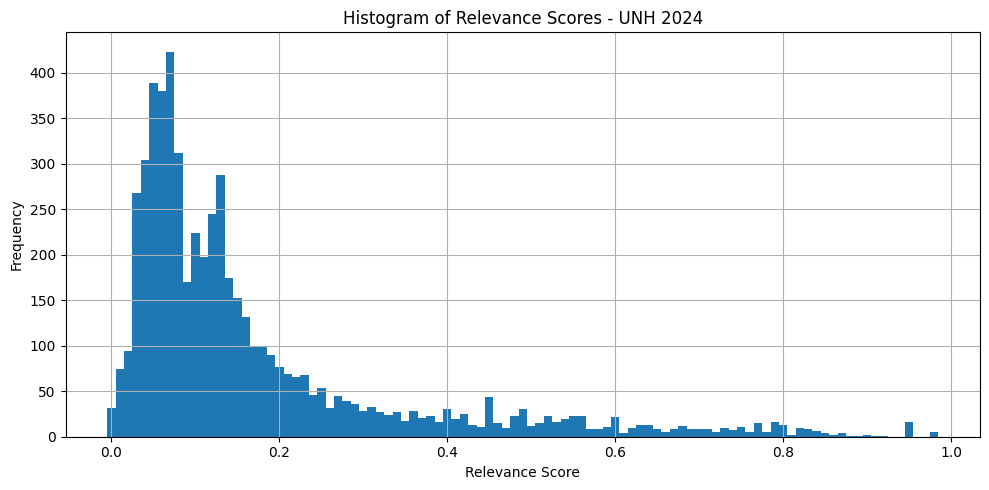

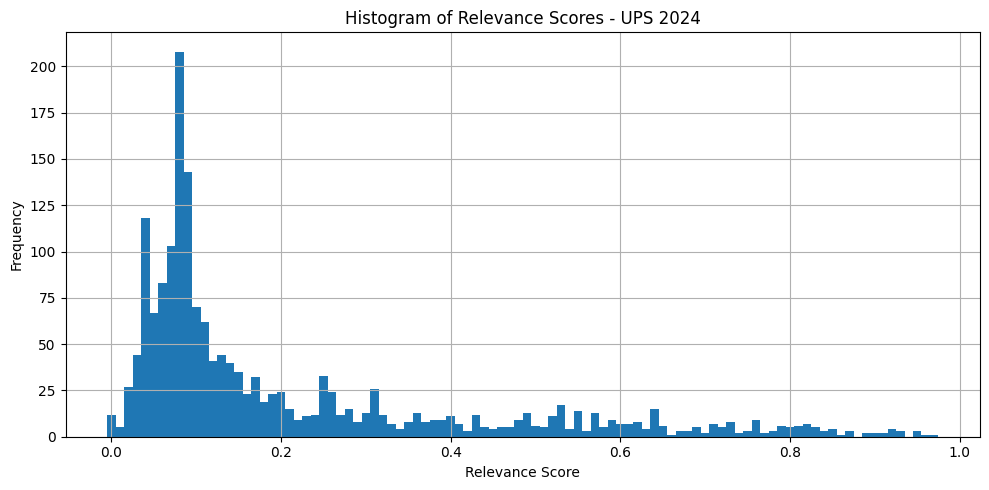

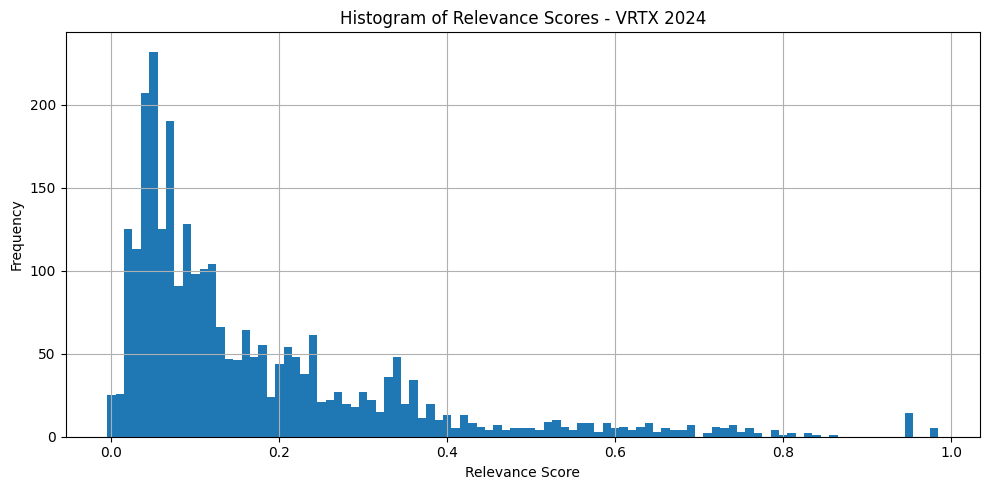

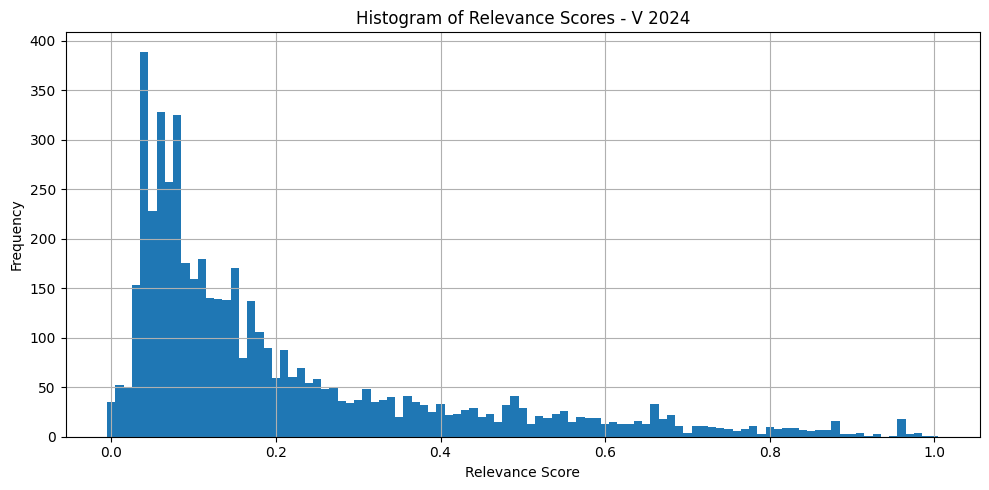

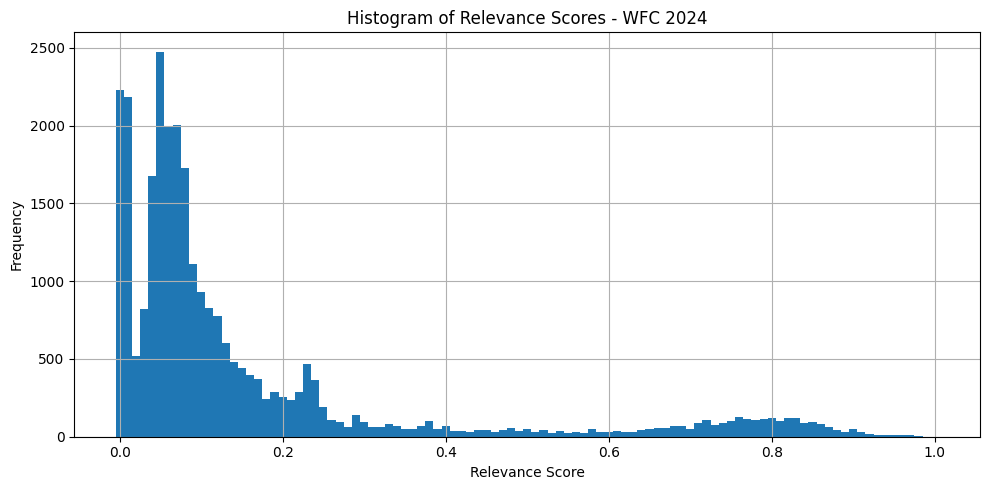

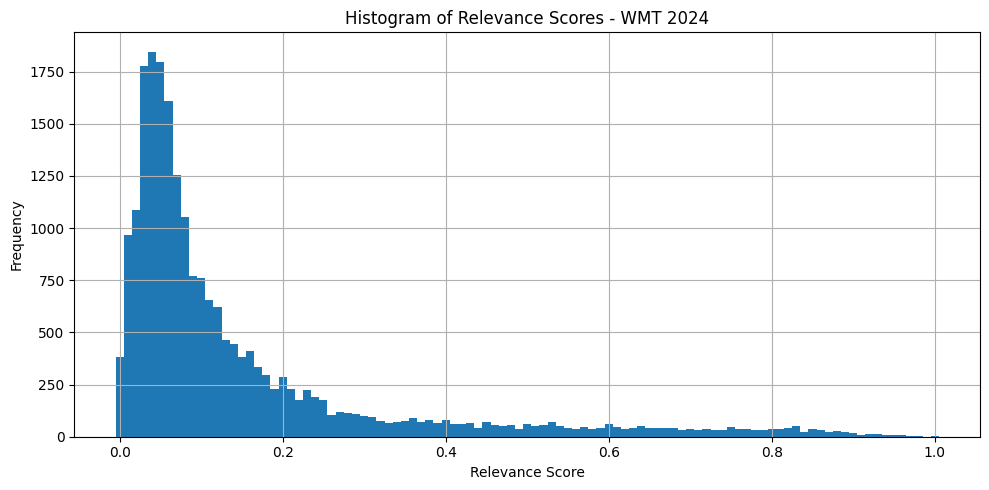

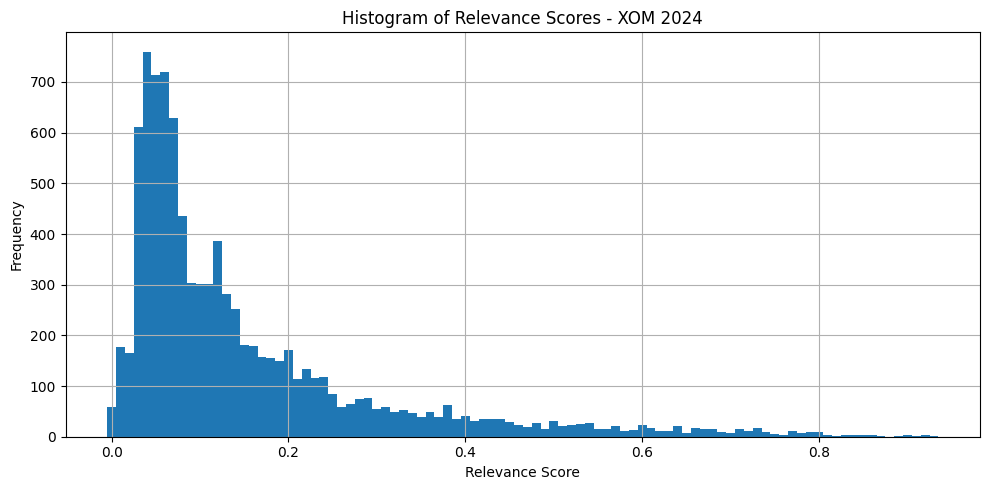

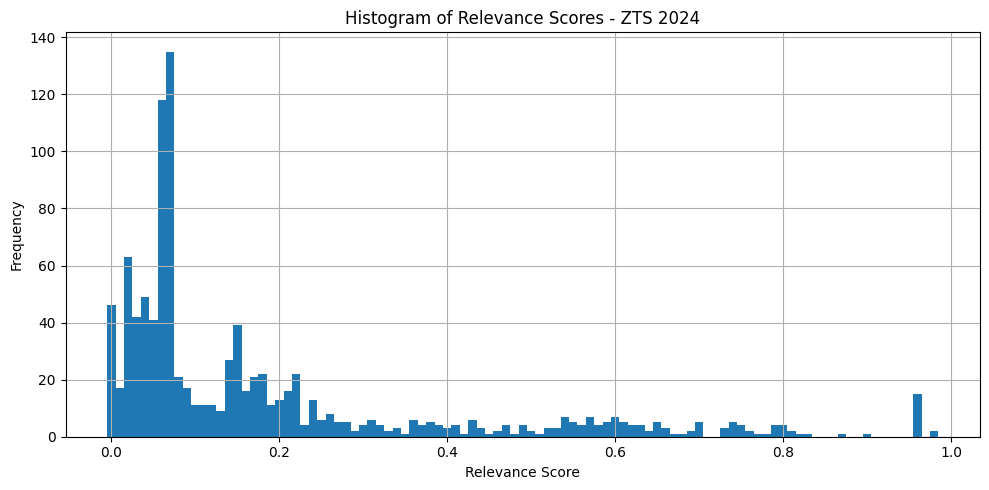

In [20]:
import json
import matplotlib.pyplot as plt
from collections import Counter
import glob
import os

# Folder containing the files
folder_path = "alphavantage_news_json_byYear"

# Get all files matching the pattern *_2024.json
file_paths = glob.glob(os.path.join(folder_path, "*_2024.json"))

for file_path in file_paths:
    # Extract ticker from filename (e.g., AAPL from AAPL_2024.json)
    ticker = os.path.basename(file_path).split("_")[0]

    # Load the data
    with open(file_path, "r", encoding="utf-8") as f:
        articles = json.load(f)

    # Collect relevance scores
    relevance_scores = []
    for article in articles:
        for sentiment in article.get("ticker_sentiment", []):
            score_str = sentiment.get("relevance_score")
            if score_str is not None:
                try:
                    score = float(score_str)
                    relevance_scores.append(round(score, 2))
                except ValueError:
                    pass

    if not relevance_scores:
        print(f"No relevance scores found in {ticker}_2024.json")
        continue

    # Count frequencies
    score_counts = Counter(relevance_scores)

    # Plot histogram
    plt.figure(figsize=(10, 5))
    plt.bar(score_counts.keys(), score_counts.values(), width=0.01)
    plt.xlabel("Relevance Score")
    plt.ylabel("Frequency")
    plt.title(f"Histogram of Relevance Scores - {ticker} 2024")
    plt.grid(True)
    plt.tight_layout()

    # Show or save the plot
    plt.show()
    # Or to save: plt.savefig(f"{ticker}_2024_relevance_hist.png")

    plt.close()


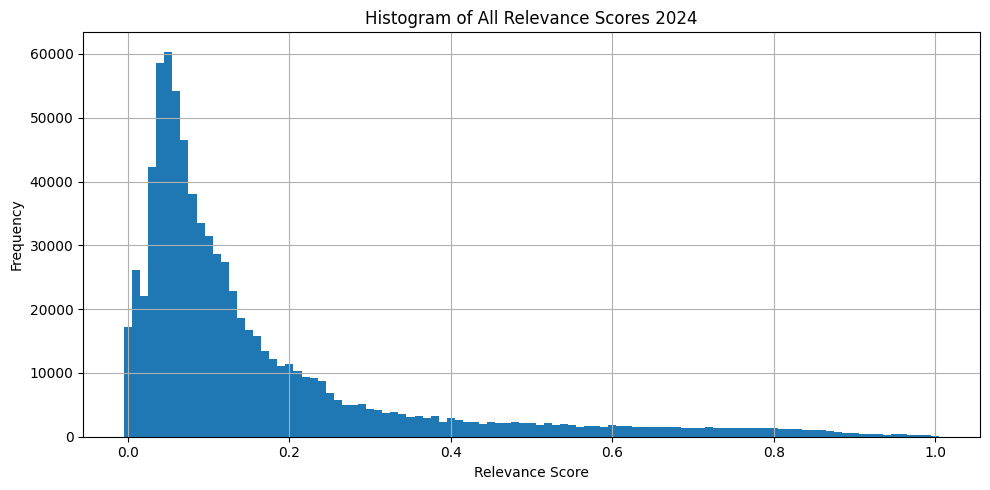

In [21]:
import json
import matplotlib.pyplot as plt
from collections import Counter
import glob
import os

# Folder containing the files
folder_path = "alphavantage_news_json_byYear"

# Get all files matching the pattern *_2024.json
file_paths = glob.glob(os.path.join(folder_path, "*_2024.json"))

all_relevance_scores = []
score_url_pairs = []  # (score, url) tuples

for file_path in file_paths:
    # Extract ticker from filename (e.g., AAPL from AAPL_2024.json)
    ticker = os.path.basename(file_path).split("_")[0]

    # Load the data
    with open(file_path, "r", encoding="utf-8") as f:
        articles = json.load(f)

    # Collect relevance scores
    ticker_relevance_scores = []

    for article in articles:
        article_url = article.get("url")
        for sentiment in article.get("ticker_sentiment", []):
            score_str = sentiment.get("relevance_score")
            if score_str is not None:
                try:
                    score = float(score_str)
                    score_rounded = round(score, 2)
                    ticker_relevance_scores.append(score_rounded)
                    all_relevance_scores.append(score_rounded)
                    score_url_pairs.append((score, article_url))
                except ValueError:
                    pass

    if not ticker_relevance_scores:
        print(f"No relevance scores found in {ticker}_2024.json")
        continue

# Count frequencies
total_counts = Counter(all_relevance_scores)


# Plot histogram
plt.figure(figsize=(10, 5))
plt.bar(total_counts.keys(), total_counts.values(), width=0.01)
plt.xlabel("Relevance Score")
plt.ylabel("Frequency")
plt.title(f"Histogram of All Relevance Scores 2024")
plt.grid(True)
plt.tight_layout()

# Show or save the plot
plt.show()
# Or to save: plt.savefig(f"{ticker}_2024_relevance_hist.png")

plt.close()


In [22]:
import numpy as np

# Convert relevance_scores to a NumPy array
scores_array = np.array(all_relevance_scores)

# Calculate five-number summary
min_val = np.min(scores_array)
q1 = np.percentile(scores_array, 25)
median = np.median(scores_array)
average = np.average(scores_array)
q3 = np.percentile(scores_array, 75)
max_val = np.max(scores_array)

# Print summary
print(f"Five-number summary for all tickers:")
print(f"Min: {min_val}")
print(f"Q1 : {q1}")
print(f"Median: {median}")
print(f"Average: {average}")
print(f"Q3 : {q3}")
print(f"Max: {max_val}")
print()

Five-number summary for all tickers:
Min: 0.0
Q1 : 0.05
Median: 0.09
Average: 0.16312569834515842
Q3 : 0.19
Max: 1.0



## Scrape to .html

In [ ]:
from selenium.common import TimeoutException
import os
import json
import random
import time
from datetime import datetime
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup

# --- User-Agent and headers setup ---
USER_AGENTS = [
    "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/122.0.0.0 Safari/537.36",
    "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:122.0) Gecko/20100101 Firefox/122.0",
]

user_agent = random.choice(USER_AGENTS)

# --- Configure Chrome ---
options = Options()
# options.add_argument("--headless")  # Uncomment to hide browser
options.add_argument("--disable-gpu")
options.add_argument("--no-sandbox")
options.add_argument(f"user-agent={user_agent}")
options.add_argument("window-size=1920,1080")

# Create output folder
OUTPUT_FOLDER = f"{datetime.now().strftime('%Y%m%d')}_scraping_AV_texts"
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

# --- Example filtered URL list (replace with your real `score_url_pairs`) ---
# Example for context:
# score_url_pairs = [(0.31, "https://www.benzinga.com/article1"), (0.42, "https://www.investors.com/article2")]
filtered_urls = [url for score, url in score_url_pairs if score > 0.2]

print(f"\n🔗 URLs with relevance score > 0.2 ({len(filtered_urls)} found)")

def accept_benzinga_cookie_banner(driver):
    try:
        # Try finding by text (safest, language-independent)
        accept_btn = WebDriverWait(driver, 10).until(
            EC.element_to_be_clickable((By.XPATH, "//a[.//span[text()='Alle akzeptieren']]"))
        )
        accept_btn.click()
        print("✅ Clicked 'Alle akzeptieren' (by exact text)")
        return True

    except TimeoutException:
        # Try fallback using partial class name
        try:
            accept_btn = WebDriverWait(driver, 5).until(
                EC.element_to_be_clickable((By.CSS_SELECTOR, "a.cmpboxbtnyes"))
            )
            accept_btn.click()
            print("✅ Clicked 'Alle akzeptieren' (by CSS selector)")
            return True
        except Exception as e:
            print("❌ Still couldn't find the Benzinga cookie banner:", e)
            return False
    except Exception as e:
        print("❌ Error while trying to accept Benzinga cookie banner:", e)
        return False

# --- Main Loop ---
for i, current_url in enumerate(filtered_urls, start=1):
    driver = webdriver.Chrome(options=options)
    domain = current_url.split("/")[2]
    try:
        print(f"\n🌐 Opening ({i}/{len(filtered_urls)}): {current_url}")
        driver.get(current_url)

        wait = WebDriverWait(driver, 10)

        # Wait for page to load fully
        time.sleep(2)  # adjust as needed for real-world delay

        # --- Accept cookie banner if present (common fallback) ---
        try:
            cookie_button = wait.until(EC.element_to_be_clickable((By.XPATH, "//button[contains(., 'Accept')]")))
            cookie_button.click()
            print("✅ Cookie banner accepted")
            time.sleep(2)
        except:
            print("⚠️ No cookie banner appeared or could not be clicked")


        # --- Show browser for inspection ---
        print(f"🔍 Loaded: {current_url}")
        # input("🕵️‍♂️ Press Enter to continue to the next URL...")

        # --- Save HTML for later parsing ---
        filename = f"{OUTPUT_FOLDER}/{domain.replace('.', '_')}_{i}.html"
        with open(filename, "w", encoding="utf-8") as f:
            f.write(driver.page_source)
        print(f"💾 Saved HTML: {filename}")

    finally:
        driver.quit()


## Scrape to Kafka

In [19]:
import sys
from selenium.common import TimeoutException
import os
import json
import random
import time
from datetime import datetime
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup, Comment
from confluent_kafka import Producer, KafkaError
from datetime import datetime
import json

# KAFKA config
conf = {'bootstrap.servers': '172.29.16.101:9092'}
producer = Producer(conf)
topic = 'g3-raw-html-test'

# --- User-Agent and headers setup ---
USER_AGENTS = [
    "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/122.0.0.0 Safari/537.36",
    "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:122.0) Gecko/20100101 Firefox/122.0",
]

user_agent = random.choice(USER_AGENTS)

# --- Configure Chrome ---
options = Options()
options.add_argument("--headless")  # Uncomment to hide browser
options.add_argument("--disable-gpu")
options.add_argument("--no-sandbox")
options.add_argument(f"user-agent={user_agent}")
options.add_argument("window-size=1920,1080")

# Create output folder
OUTPUT_FOLDER = f"{datetime.now().strftime('%Y%m%d')}_scraping_AV_texts"
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

# --- Example filtered URL list (replace with your real `score_url_pairs`) ---
# Example for context:
# score_url_pairs = [(0.31, "https://www.benzinga.com/article1"), (0.42, "https://www.investors.com/article2")]
filtered_urls = [url for score, url in score_url_pairs if score > 0.2]

print(f"\n🔗 URLs with relevance score > 0.2 ({len(filtered_urls)} found)")

def clean_html(raw_html):
    soup = BeautifulSoup(raw_html, "html.parser")

    # Remove unwanted tags completely
    for tag in soup(["script", "style", "noscript", "iframe", "svg"]):
        tag.decompose()

    # Remove comments
    for comment in soup.find_all(string=lambda text: isinstance(text, Comment)):
        comment.extract()

    for tag in soup(["header", "footer", "nav", "aside"]):
        tag.decompose()

    return str(soup)

# --- Main Loop ---
for i, current_url in enumerate(filtered_urls, start=1):
    driver = webdriver.Chrome(options=options)
    domain = current_url.split("/")[2]
    try:
        print(f"\n🌐 Opening ({i}/{len(filtered_urls)}): {current_url}")
        driver.get(current_url)

        wait = WebDriverWait(driver,0.5)

        # Wait for page to load fully
        time.sleep(2)  # adjust as needed for real-world delay

        # --- Accept cookie banner if present (common fallback) ---
        try:
            cookie_button = wait.until(EC.element_to_be_clickable((By.XPATH, "//button[contains(., 'Accept')]")))
            cookie_button.click()
            print("✅ Cookie banner accepted")
            time.sleep(0.5)
        except:
            print("⚠️ No cookie banner appeared or could not be clicked")

        print(f"🔍 Loaded: {current_url}")

        raw_html = driver.page_source
        pure_html = clean_html(raw_html)
        print(f"Before html cleaning: {len(raw_html) / 1024:.2f} KB")
        print(f"After html cleaning: {len(pure_html) / 1024:.2f} KB")


            # --- Prepare data payload ---
        data = {
            'url': current_url,
            'html': pure_html,
            'timestamp': datetime.now().isoformat()
        }

        # --- Save JSON to file ---
        filename = f"{OUTPUT_FOLDER}/{domain.replace('.', '_')}_{i}.json"
        with open(filename, "w", encoding="utf-8") as f:
            json.dump(data, f, indent=2, ensure_ascii=False)
        print(f"💾 Saved JSON: {filename}")

        try:
            message = json.dumps(data)
            print(f"Kafka message size: {sys.getsizeof(message) / 1024:.2f} KB")

            producer.produce(topic, value=message)
            producer.flush(0)
            print(f'🚀 Flushed to Kafka broker with topic "{topic}"')

        except BufferError as e:
            print(f"❌ Kafka BufferError: {e} — queue is full?")
        except KafkaError as e:
            print(f"❌ KafkaError: {e}")
        except Exception as e:
            print(f"❌ Unexpected error: {e}")

    finally:
        driver.quit()



🔗 URLs with relevance score > 0.2 (190195 found)

🌐 Opening (1/190195): https://www.benzinga.com/general/24/01/36444463/buffetts-bullseye-meet-the-4-stocks-that-make-up-nearly-75-of-his-portfolio
⚠️ No cookie banner appeared or could not be clicked
🔍 Loaded: https://www.benzinga.com/general/24/01/36444463/buffetts-bullseye-meet-the-4-stocks-that-make-up-nearly-75-of-his-portfolio
Before html cleaning: 400.14 KB
After html cleaning: 123.04 KB
💾 Saved JSON: 20250529_scraping_AV_texts/www_benzinga_com_1.json
Kafka message size: 128.28 KB
🚀 Flushed to Kafka broker with topic "g3-raw-html-test"

🌐 Opening (2/190195): https://www.benzinga.com/general/24/01/36444463/buffetts-bullseye-meet-the-4-stocks-that-make-up-nearly-75-of-his-portfolio
⚠️ No cookie banner appeared or could not be clicked
🔍 Loaded: https://www.benzinga.com/general/24/01/36444463/buffetts-bullseye-meet-the-4-stocks-that-make-up-nearly-75-of-his-portfolio
Before html cleaning: 392.04 KB
After html cleaning: 122.95 KB
💾 Sav

KeyboardInterrupt: 